In [1]:
import pandas as pd
import numpy as np

#Create the portfolio
portfolio = pd.DataFrame(["AAA"]*10+["AA"]*10+["A"]*10, columns = ['Rating'])
portfolio = pd.DataFrame(["BBB"]*10+["BB"]*10+["B"]*10, columns = ['Rating'])


portfolio['Coupon Rate'] = [.08] * 10 + [.09] * 10 + [.1] * 10
portfolio['Payment Frequency'] = [6,12] * 15
portfolio['Face Value'] = 1000

#Set initial portfolio
initial_state = {
    'portfolio': portfolio,
    'default': 0,
    'r': .06,
    'cash': 0,
    'payment': 0
}

#Credit transition matrix (yearly) from: https://www.msci.com/documents/10199/93396227-d449-4229-9143-24a94dab122f
transition_matrix = pd.DataFrame([[.9081, .0833,.0068,.0006,.0012,0,0,0],
                                 [.0070,.9065,.0779,.0064,.0006,.0014,.0002,0],
                                 [.0009,.0227,.9105,.0552,.0074,.0026,.0001,.0006],
                                 [.0002, .0033, .0595, .8693, .0530,.0117,.0012,.0018],
                                 [.0003, .0014,.0067,.0773,.8053,.0884, .0100, .0106],
                                 [0, .0011, .0024, .0043, .0648, .8346, .0407, .0521],
                                 [.0022, 0, .0022, .0130, .0238, .1124, .6486, .1978],
                                 [0,0,0,0,0,0,0,1]],
                                 index=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"],
                                columns=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"])


#Convert to monthly transition matrix
u, V = np.linalg.eig(transition_matrix)
P = V
D = np.diag(u)
transition_matrix_monthly = pd.DataFrame(P.dot(D ** (1/12)).dot(np.linalg.inv(P)),
                                        index=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"],
                                columns=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"])

#Get rid of the rounding error negative numbers
transition_matrix_monthly = transition_matrix_monthly.clip(0)
#Renormalize
transition_matrix_monthly = transition_matrix_monthly.multiply(1/transition_matrix_monthly.sum(axis=1), axis=0)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

#Step 1: Create the credit transition
#Function to transition the matrix randomly, updated to use dataframe
def credit_migration(_params, substep, sH, s):
    portfolio = s['portfolio']
    portfolio['Rating'] = portfolio['Rating'].map(lambda x: np.random.RandomState().choice(
  transition_matrix_monthly.index, 
  p=transition_matrix_monthly.loc[x].values))
    return ({"portfolio": portfolio})

#Update the ratings    
def update_portfolio(_params, substep, sH, s, _input):
    return ('portfolio', _input['portfolio'])

#Function to value the portfolio, for now just finding default %
def value_portfolio(_params, substep, sH, s):
    return {"default": (s['portfolio']['Rating'] == "Default").sum() / len(s['portfolio']['Rating'])}

#Update the value
def update_value(_params, substep, sH, s, _input):
    return ('default', _input['default'])


#Create partial updates
PSUBs = [
    {
        "policies": {
            "migration_policy": credit_migration,
        },
        "variables": {
            "portfolio": update_portfolio,
        }
    },
        {
        "policies": {
            "valuation_policy": value_portfolio,
        },
        "variables": {
            "default": update_value,
        }
    }
]

sim_config_dict = {
    'T': range(360),
    'N': 5}
c = config_sim(sim_config_dict)

exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)

#Execute!
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 1, 5, 5)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4]
ExpIDs   : [0, 0, 0, 0, 0]
Total execution time: 20.36s


In [3]:
print(result)

                                              portfolio   default     r  cash  \
0        Rating  Coupon Rate  Payment Frequency  Fac...  0.000000  0.06     0   
1        Rating  Coupon Rate  Payment Frequency  Fac...  0.000000  0.06     0   
2        Rating  Coupon Rate  Payment Frequency  Fac...  0.000000  0.06     0   
3        Rating  Coupon Rate  Payment Frequency  Fac...  0.000000  0.06     0   
4        Rating  Coupon Rate  Payment Frequency  Fac...  0.000000  0.06     0   
...                                                 ...       ...   ...   ...   
3600       Rating  Coupon Rate  Payment Frequency  F...  0.633333  0.06     0   
3601       Rating  Coupon Rate  Payment Frequency  F...  0.633333  0.06     0   
3602       Rating  Coupon Rate  Payment Frequency  F...  0.666667  0.06     0   
3603       Rating  Coupon Rate  Payment Frequency  F...  0.666667  0.06     0   
3604       Rating  Coupon Rate  Payment Frequency  F...  0.666667  0.06     0   

      payment  simulation  

In [4]:
import pathos
pathos.helpers.shutdown()
configs.clear()

In [5]:
#Step 2: Add in payments
#Function to compute bond payments
def bond_payments(_params, substep, sH, s):
    portfolio = s['portfolio']
    #Compute coupon payments 
    payment = (((s['timestep']) % portfolio['Payment Frequency']) == 0).astype(int) * portfolio['Coupon Rate'] * portfolio['Face Value'] * portfolio['Payment Frequency'] / 12
    
    #If the timestep is equal to 360, add the face value
    payment = payment + portfolio['Face Value'] * ((s['timestep']) % 360 == 0)
    
    #Set payments for defaulted bonds equal to 0
    payment = payment * (portfolio['Rating'] != 'Default').astype(int)
    
    
    
    
    payment = payment.sum()
    return ({"payment": payment})

#Update the payment    
def update_payments(_params, substep, sH, s, _input):
    return ('payment', _input['payment'])

#Compute cash
def cash_change(_params, substep, sH, s):
    cash = s['cash'] * (1+s['r']) ** (1/12)
    cash += s['payment']
    return ({"cash": cash})

#Update cash
def update_cash(_params, substep, sH, s, _input):
    return ('cash', _input['cash'])

PSUBs = [
        { 
        'policies': {
            'credit_policy': credit_migration
        },
        'variables': {
            'portfolio': update_portfolio
            
        }
    },
        { 
        'policies': {
            'default_policy': value_portfolio
        },
        'variables': {
            'default': update_value
            
        }
    },
    { 
        'policies': {
            'payment_policy': bond_payments
        },
        'variables': {
            'payment': update_payments
            
        }
    },
        { 
        'policies': {
            'cash_policy': cash_change
        },
        'variables': {
            'cash': update_cash
            
        }
    }
]

sim_config_dict = {
    'T': range(360),
    'N': 5}
c = config_sim(sim_config_dict)

exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)

#Execute!
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 1, 5, 5)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4]
ExpIDs   : [0, 0, 0, 0, 0]
Total execution time: 26.93s


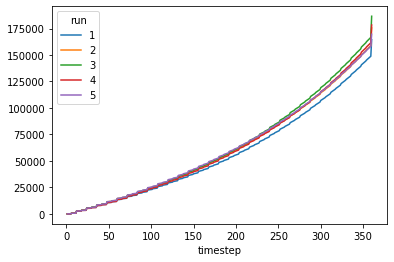

In [6]:
#Now we see that there is a difference between payments/cash position given whether bonds are defaulting 
result[result['substep'] == 4].pivot('timestep','run', 'cash').plot(kind='line')
plt.show()

In [7]:
pathos.helpers.shutdown()
configs.clear()

In [8]:
#Step 3: Add in the rate change component
from scipy.stats import norm

#Basic vasicek rate change model
def rate_change(r, a=.5, b=.06, sigma=.02, t=1/12):
    delta = a* (b-r) * t + sigma * t ** .5 * norm.ppf(np.random.RandomState().rand())
    return delta + r


#Policy for updating
def vasicek_policy(_params, substep, sH, s):
    r = rate_change(s['r'], _params['a'], _params['b'], _params['sigma'], _params['t'])
    return {'r': r}

#Simple state update
def update_rate(_params, substep, sH, s, _input):
    return ('r', _input['r'])



PSUBs = [
        { 
        'policies': {
            'credit_policy': credit_migration
        },
        'variables': {
            'portfolio': update_portfolio
            
        }
    },
        { 
        'policies': {
            'default_policy': value_portfolio
        },
        'variables': {
            'default': update_value
            
        }
    },
    { 
        'policies': {
            'payment_policy': bond_payments
        },
        'variables': {
            'payment': update_payments
            
        }
    },
        { 
        'policies': {
            'cash_policy': cash_change
        },
        'variables': {
            'cash': update_cash
            
        }
    },
            { 
        'policies': {
            'rate_policy': vasicek_policy
        },
        'variables': {
            'r': update_rate
            
        }
    }
]




sim_config_dict = {
    'T': range(360),
    'N': 6,
"M": {'a': [.5], 'b':[.04], 'sigma':[.02], 't':[1/12]}
}
c = config_sim(sim_config_dict)

exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)

#Execute!
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 4, 6, 5)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4, 5]
ExpIDs   : [0, 0, 0, 0, 0, 0]
Total execution time: 32.42s


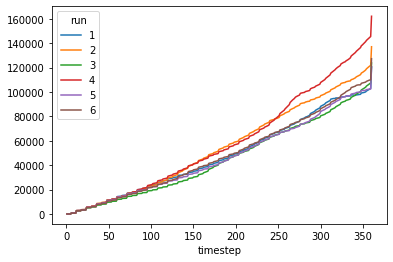

In [9]:
#Rates changing adds more complexity, now the cash is re-invested at different rates
result[result['substep'] == 5].pivot('timestep','run', 'cash').plot(kind='line')
plt.show()

In [10]:
pathos.helpers.shutdown()
configs.clear()

sim_config_dict = {
    'T': range(360),
    'N': 100,
"M": {'a': [.5], 'b':[.04], 'sigma':[.02], 't':[1/12]}
}
c = config_sim(sim_config_dict)

exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)

#Execute!
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 4, 100, 5)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

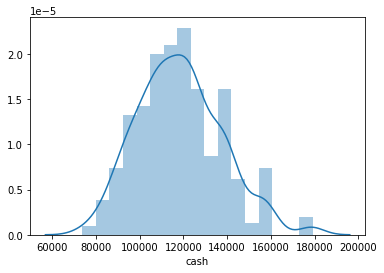

In [11]:
#Plot terminal cash distribution
import seaborn as sns

sns.distplot(result[result['timestep'] == 360]['cash'], kde=True)
plt.show()

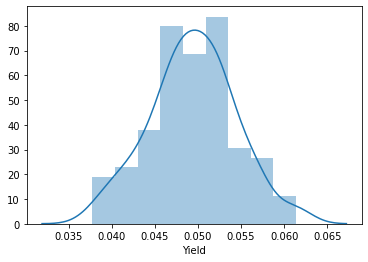

In [12]:
#Plot yields distribution

yields = result[(result['timestep'] == 360) & (result['substep'] == 5)]['cash']
yields = (yields / 30000) ** (1/30) - 1
yields.name = 'Yield'
sns.distplot(yields, kde=True)
plt.show()

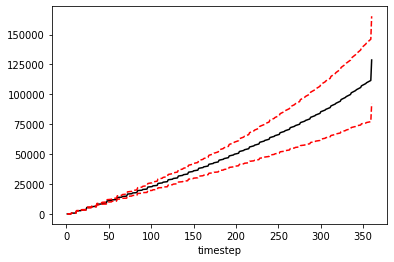

In [14]:
#Find the bounds for two standard deviations around cash

cash = result[result['substep'] == 5].pivot("timestep", "run", "cash")
mu = cash.mean(axis=1)
std = cash.std(axis=1)
lower_bound = mu - 2 * std
upper_bound = mu + 2 * std

mu.plot(kind='line', color='black')
lower_bound.plot(kind='line', color='red', linestyle='--')
upper_bound.plot(kind='line', color='red', linestyle='--')
plt.show()

In [15]:
import pandas as pd
import numpy as np

#Create the portfolio
portfolio1 = pd.DataFrame(["AAA"]*10+["AA"]*10+["A"]*10, columns = ['Rating'])
portfolio2 = pd.DataFrame(["BBB"]*10+["BB"]*10+["B"]*10, columns = ['Rating'])


portfolio1['Coupon Rate'] = [.05] * 10 + [.06] * 10 + [.07] * 10
portfolio1['Payment Frequency'] = [6,12] * 15
portfolio1['Face Value'] = 1000

portfolio2['Coupon Rate'] = [.08] * 10 + [.09] * 10 + [.1] * 10
portfolio2['Payment Frequency'] = [6,12] * 15
portfolio2['Face Value'] = 1000

#Set initial portfolios
initial_state1 = {
    'portfolio': portfolio1,
    'default': 0,
    'r': .06,
    'cash': 0,
    'payment': 0
}

initial_state2 = {
    'portfolio': portfolio2,
    'default': 0,
    'r': .06,
    'cash': 0,
    'payment': 0
}

In [16]:
pathos.helpers.shutdown()
configs.clear()

sim_config_dict1 = {
    'T': range(360),
    'N': 100,
"M": {'a': [.5], 'b':[.04], 'sigma':[.02], 't':[1/12]}
}
c1 = config_sim(sim_config_dict1)

sim_config_dict2 = {
    'T': range(360),
    'N': 100,
"M": {'a': [.5], 'b':[.04], 'sigma':[.02], 't':[1/12]}
}
c2 = config_sim(sim_config_dict2)

exp = Experiment()
exp.append_configs(
    initial_state = initial_state1,
    partial_state_update_blocks = PSUBs,
    sim_configs = c1
)

exp = Experiment()

exp.append_configs(
    initial_state = initial_state2,
    partial_state_update_blocks = PSUBs,
    sim_configs = c2
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 2
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 4, 100, 5)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Subse

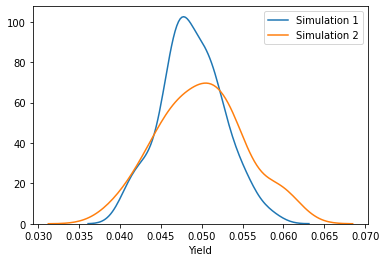

In [17]:
yields = result[(result['timestep'] == 360) & (result['substep'] == 5)].copy()
yields['Yield'] = (yields['cash'] / 30000) ** (1/30) - 1


sns.distplot(yields[yields['simulation'] == 0]['Yield'], kde=True, hist=False, label='Simulation 1')
sns.distplot(yields[yields['simulation'] == 1]['Yield'], kde=True, hist=False, label='Simulation 2')
plt.legend()

plt.show()